# Import the necesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pmd
from statsmodels.tsa.arima.model import ARIMA
from scipy.spatial import KDTree
from scipy.special import psi
from nolitsa import delay, dimension
from scipy.spatial import KDTree

# Helper Functions



In [2]:
def plot_timeseries(xV, get_histogram=False, title='', savepath=''):
    # #plot timeseries
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.plot(xV, marker='x', linestyle='--', linewidth=2);
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    if len(title) > 0:
        ax.set_title(title, x=0.5, y=1.0);
    plt.tight_layout()
    if len(savepath) > 0:
        plt.savefig(f'{savepath}/{title}_xM.jpeg')
    # #plot histogram
    if get_histogram:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.hist(xV, alpha=0.8, rwidth=0.9);
        ax.set_xlabel('value')
        ax.set_title('Histogram')
        plt.tight_layout()
        if len(title) > 0:
            ax.set_title(title, x=0.5, y=1.0);
        plt.tight_layout()
        if len(savepath) > 0:
            plt.savefig(f'{savepath}/{title}_hist.jpeg')

def seasonal_components(xV, period):
    '''
    computes the periodic time series comprised of repetetive
    patterns of seasonal components given a time series and the season
    (period).
    '''
    n = xV.shape[0]
    sV = np.full(shape=(n,), fill_value=np.nan)
    monV = np.full(shape=(period,), fill_value=np.nan)
    for i in np.arange(period):
        monV[i] = np.mean(xV[i:n:period])
    monV = monV - np.mean(monV)
    for i in np.arange(period):
        sV[i:n:period] = monV[i] * np.ones(shape=len(np.arange(i, n, period)))
    return sV

def get_acf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate acf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    acfV = acf(xV, nlags=lags)[1:]
    z_inv = norm.ppf(1 - alpha / 2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, lags + 1), acfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1 - alpha) * 100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('ACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags + 1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return acfV


def get_pacf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate pacf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    pacfV = pacf(xV, nlags=lags, method='ols-adjusted')[1:]
    z_inv = norm.ppf(1 - alpha / 2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, lags + 1), pacfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1 - alpha) * 100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('PACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags + 1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return pacfV

def portmanteau_test(xV, maxtau, show=False):
    '''
    PORTMANTEAULB hypothesis test (H0) for independence of time series:
    tests jointly that several autocorrelations are zero.
    It computes the Ljung-Box statistic of the modified sum of
    autocorrelations up to a maximum lag, for maximum lags
    1,2,...,maxtau.
    '''
    ljung_result = acorr_ljungbox(xV, lags=maxtau)
    
    # Extract the 'lb_stat' and 'lb_pvalue' columns from the DataFrame
    ljung_val = ljung_result['lb_stat'].values
    ljung_pval = ljung_result['lb_pvalue'].values
    
    if show:
        fig, ax = plt.subplots(1, 1)
        # # FOR DEBUGGING PURPOSES:
        # print(f"ljung_pval: {ljung_pval}")
        # print(f"np.arange(len(ljung_pval)): {np.arange(len(ljung_pval))}")
        ax.scatter(np.arange(len(ljung_pval)), ljung_pval)
        ax.axhline(0.05, linestyle='--', color='r')
        ax.set_title('Ljung-Box Portmanteau test')
        ax.set_yticks(np.arange(0, 1.1))
        plt.show()
    
    return ljung_val, ljung_pval


def arimamodel(xV):
    '''
    BUILT-IN SOLUTION FOR DETECTING BEST ARIMA MODEL MINIMIZING AIC
    https://alkaline-ml.com/pmdarima/index.html
    '''
    autoarima_model = pmd.auto_arima(xV,
                                     start_p=1, start_q=1,
                                     max_p=5, max_q=5,
                                     test="adf", stepwise=False,
                                     trace=True, information_criterion='aic')
    return autoarima_model

def fit_arima_model(xV, p, q, d=0, show=False):
    '''
    fit ARIMA(p, d, q) in xV
    returns: summary (table), fittedvalues, residuals, model, AIC
    '''
    try:
        model = ARIMA(xV, order=(p, d, q)).fit()
    except:
        return np.nan
    summary = model.summary()
    fittedvalues = model.fittedvalues
    fittedvalues = np.array(fittedvalues).reshape(-1, 1)
    resid = model.resid
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(xV, label='Original', color='blue')
        ax.plot(fittedvalues, label='FittedValues', color='red', linestyle='--', alpha=0.9)
        ax.legend()
        ax.set_title(f'ARIMA({p}, {d}, {q})')
        fig, ax = plt.subplots(2, 1, figsize=(14, 8))
        ax[0].hist(resid, label='Residual')
        ax[1].scatter(np.arange(len(resid)), resid)
        ax[1].axhline(0, linestyle='--', color='red')
        plt.title('Residuals')
        plt.legend()
    return summary, fittedvalues, resid, model, model.aic

def calculate_fitting_error(xV, model, Tmax=20, show=False,original=False, s=None):
    '''
    calculate fitting error with NRMSE for given model in timeseries xV
    till prediction horizon Tmax
    returns:
    nrmseV
    preds: for timesteps T=1, 2, 3
    '''
    nrmseV = np.full(shape=Tmax, fill_value=np.nan)
    nobs = len(xV)
    xV_std = np.std(xV)
    vartar = np.sum((xV - np.mean(xV)) ** 2)
    predM = []
    tmin = np.max(
        [len(model.arparams), len(model.maparams), 1])  # start prediction after getting all lags needed from model
    for T in np.arange(1, Tmax):
        errors = []
        predV = np.full(shape=nobs, fill_value=np.nan)
        for t in np.arange(tmin, nobs - T):
            pred_ = model.predict(start=t, end=t + T - 1, dynamic=True)
            # predV.append(pred_[-1])
            if original:
                ytrue = xV[t + T - 1] + s[t+T-1]    # add seasonal component
                predV[t + T - 1] = pred_[-1] + s[t+T-1]
                error = pred_[-1] - ytrue
            else:
                ytrue = xV[t + T - 1]
                predV[t + T - 1] = pred_[-1]
                error = pred_[-1] - ytrue
            errors.append(error)
        predM.append(predV)
        errors = np.array(errors)
        mse = np.mean(np.power(errors, 2))
        rmse = np.sqrt(mse)
        nrmseV[T] = (rmse / xV_std)
        # nrmseV[T] = (np.sum(errors**2) / vartar)
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, Tmax), nrmseV[1:], marker='x', label='NRMSE');
        ax.axhline(1, color='red', linestyle='--');
        ax.set_title('Fitting Error')
        ax.legend()
        ax.set_xlabel('T')
        ax.set_xticks(np.arange(1, Tmax))
        plt.show()
        # #plot multistep prediction for T=1, 2, 3
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        if original:
            xV = xV + s
        ax.plot(xV, label='original')
        colors = ['red', 'green', 'black']
        for i, preds in enumerate(predM[:3]):
            ax.plot(preds, color=colors[i], linestyle='--', label=f'T={i + 1}', alpha=0.7)
        ax.legend(loc='best')
        plt.show()
    return nrmseV, predM

def get_nrmse(target, predicted):
    se = (target - predicted) ** 2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    return rmse / np.std(target)

def nrmse(trueV, predictedV):
    vartrue = np.sum((trueV - np.mean(trueV)) ** 2)
    varpred = np.sum((predictedV - trueV) ** 2)
    return np.sqrt(varpred / vartrue)

def localfitnrmse(xV, tau, m, Tmax, nnei, q, show=''):
    '''
     LOCALFITNRMSE makes fitting using a local model of zeroth order (average
    % mapping or nearest neighbor mappings if only one neighbor is chosen) or a
    % local linear model and computes the fitting error for T-step ahead. For
    % the search for neighboring points it uses the Matlab k-d-tree search.
    % The fitting here means that predictions are made for all the points in
    % the data set (in-sample prediction). The prediction error statistic
    % (NRMSE measure) for the T-step ahead predictions is the goodness-of-fit
    % statistic.
    % The state space reconstruction is done with the method of delays having
    % as parameters the embedding dimension 'm' and the delay time 'tau'.
    % The local prediction model is one of the following:
    % Ordinary Least Squares, OLS (standard local linear model): if the
    % truncation parameter q >= m
    % Principal Component Regression, PCR, project the parameter space of the
    % model to only q of the m principal axes: if 0<q<m
    % Local Average Mapping, LAM: if q=0.
    % The local region is determined by the number of neighbours 'nnei'.
    % The k-d-tree data structure is utilized to speed up computation time in
    % the search of neighboring points and the implementation of Matlab is
    % used.
    % INPUTS:
    %  xV      : vector of the scalar time series
    %  tau     : the delay time (usually set to 1).
    %  m       : the embedding dimension.
    %  Tmax    : the prediction horizon, the fit is made for T=1...Tmax steps
    %            ahead.
    %  nnei    : number of nearest neighbors to be used in the local model.
    %            If k=1,the nearest neighbor mapping is the fitted value.
    %            If k>1, the model as defined by the input patameter 'q' is
    %            used.
    %  q       : the truncation parameter for a normalization of the local
    %            linear model if specified (to project the parameter space of
    %            the model, using Principal Component Regression, PCR, locally).
    %            if q>=m -> Ordinary Least Squares, OLS (standard local linear
    %                       model, no projection)
    %            if 0<q<m -> PCR(q)
    %            if q=0 -> local average model (if in addition nnei=1 ->
    %            then the zeroth order model is applied)
    %  tittxt  : string to be displayed in the title of the figure
    %            if not specified, no plot is made
    % OUTPUT:
    %  nrmseV  : vector of length Tmax, the nrmse of the fit for T-mappings,
    %            T=1...Tmax.
    %  preM    : the matrix of size nvec x (1+Tmax) having the fit (in-sample
    %            predictions) for T=1,...,Tmax, for each of the nvec
    %            reconstructed points from the whole time series. The first
    %            column has the time of the target point and the rest Tmax
    %            columns the fits for T=1,...,Tmax time steps ahead.
    '''
    if q > m:
        q = int(m)
    n = xV.shape[0]

    if n < 2 * (m - 1) * tau - Tmax:
        print('too short timeseries')
        return

    nvec = n - (m - 1) * tau - Tmax
    xM = np.full(shape=(nvec, m), fill_value=np.nan)

    for j in np.arange(m):
        xM[:, [m - j - 1]] = xV[j * tau:nvec + j * tau].reshape(-1, 1)
    from scipy.spatial import KDTree
    kdtreeS = KDTree(xM)
    preM = np.full(shape=(nvec, Tmax), fill_value=np.nan)
    _, nneiindM = kdtreeS.query(xM, k=nnei + 1, p=2)
    nneiindM = nneiindM[:, 1:]
    for i in np.arange(nvec):
        neiM = xM[nneiindM[i]]
        yV = xV[nneiindM[i] + m * tau]
        if q == 0 or nnei == 1:
            preM[i, 0] = np.mean(yV)
        else:
            mneiV = np.mean(neiM, axis=0)
            my = np.mean(yV)
            zM = neiM - mneiV
            [Ux, Sx, Vx] = np.linalg.svd(zM, full_matrices=False)
            Sx = np.diag(Sx)
            Vx = Vx.T
            tmpM = Vx[:, :q] @ (np.linalg.inv(Sx[:q, :q]) @ Ux[:, :q].T)
            lsbV = tmpM @ (yV - my)
            preM[i] = my + (xM[i,] - mneiV) @ lsbV
    if Tmax > 1:
        # winnowM = np.full(shape=(nvec, (m - 1) * tau + 1), fill_value=np.nan)
        winnowM = np.full(shape=(nvec, m * tau), fill_value=np.nan)  # Should be (5062, 25)
        print(f"FOR DEBUGGING : nvec: {nvec}, m: {m}, tau: {tau}\n winnowM shape: {winnowM.shape}")
        # for i in np.arange(m * tau):
        for i in range(min(m * tau, winnowM.shape[1])):  # Ensure i doesn't exceed column count
            print(f"FOR DEBUGGING : xV[{i}:{nvec + i}].shape: {xV[i:nvec + i].shape}")
            winnowM[:, [i]] = xV[i:nvec + i].reshape(-1, 1)
        for T in np.arange(2, Tmax + 1):
            winnowM = np.concatenate([winnowM, preM[:, [T - 2]]], axis=1)
            # targM = winnowM[:, :-(m + 1) * tau:-tau]
            targM = winnowM[:, -5:]  # Select the last 5 columns

            _, nneiindM = kdtreeS.query(targM, k=nnei, p=2)

            for i in np.arange(nvec):
                neiM = xM[nneiindM[i], :]
                yV = xV[nneiindM[i] + (m - 1) * tau + 1]
                if q == 0 or nnei == 1:
                    preM[i, T - 1] = np.mean(yV)
                else:
                    mneiV = np.mean(neiM, axis=0)
                    my = np.mean(yV)
                    zM = neiM - mneiV
                    [Ux, Sx, Vx] = np.linalg.svd(zM, full_matrices=False)
                    Sx = np.diag(Sx)
                    Vx = Vx.T
                    tmpM = Vx[:, :q] @ (np.linalg.inv(Sx[:q, :q]) @ Ux[:, :q].T)
                    lsbV = tmpM @ (yV - my)
                    preM[i, T - 1] = my + (targM[i, :] - mneiV) @ lsbV

    nrmseV = np.full(shape=(Tmax, 1), fill_value=np.nan)
    idx = (np.arange(nvec) + (m - 1) * tau).astype(int)
    for t_idx in np.arange(1, Tmax + 1):
        nrmseV[t_idx - 1] = get_nrmse(target=xV[idx + t_idx,], predicted=preM[:, [t_idx - 1]])
    if show:
        fig, ax = plt.subplots(1, 1)
        ax.plot(np.arange(1, Tmax + 1), nrmseV, marker='x')
        ax.set_xlabel('prediction time T')
        ax.set_ylabel('NRMSE(T)')
    return nrmseV, preM


def ANN(X, k):
    '''
    helper func
    '''
    tree = KDTree(X, leaf_size=1, metric='chebyshev')
    dists, nnidx = tree.query(X, k=k)
    del tree
    return nnidx, dists


def ANNR(X, rV):
    '''
    helper func
    '''
    tree = KDTree(X, leaf_size=1, metric='chebyshev')
    nnnidx = tree.query_radius(X, r=rV, count_only=True)
    return nnnidx

def nneighforgivenr(X, rV):
    '''
    helper func
    '''
    npV = ANNR(X, rV)
    npV[npV == 0] = 1
    return npV

def mi_estimator_ksg1(xV, yV, nnei=5, normalize=False):
    '''
    calculates I(X;Y) using KSG algorithm1 (with max-norms squares)
    '''
    

    n = xV.shape[0]
    psi_nnei = psi(nnei)
    psi_n = psi(n)

    if normalize:
        xV = (xV - np.min(xV)) / np.ptp(xV)
        yV = (yV - np.min(yV)) / np.ptp(yV)

    xembM = np.concatenate((xV, yV), axis=1)
    _, distsM = ANN(xembM, nnei + 1)
    maxdistV = distsM[:, -1]
    n_x = nneighforgivenr(X=xV, rV=maxdistV - np.ones(n) * 10 ** (-10))
    n_y = nneighforgivenr(X=yV, rV=maxdistV - np.ones(n) * 10 ** (-10))
    psibothM = psi(np.concatenate((n_x.reshape(-1, 1), n_y.reshape(-1, 1)), axis=1))
    #     # I(X;Y) = ψ(k) + ψ(Ν) - <ψ(Nx + 1) + ψ(Ny + 1)>
    mi = psi_nnei + psi_n - np.mean(np.sum(psibothM, axis=1))
    return mi


def falsenearestneighbors(xV, m_max=10, tau=1, show=False):
    dim = np.arange(1, m_max + 1)
    f1, _, _ = dimension.fnn(xV, tau=tau, dim=dim, window=10, metric='cityblock', parallel=False)
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.scatter(dim, f1)
        ax.axhline(0.01, linestyle='--', color='red', label='1% threshold')
        ax.set_xlabel(f'm')
        ax.set_title(f'FNN ({m_max})')
        ax.set_xticks(dim)
        ax.legend()
        plt.show()
    return f1


# Preprocess the data

In [3]:
data_df = pd.read_csv('train.csv')
team_number = 11
team_data = data_df.iloc[:, team_number + 1]

#turn the data into a numpy array
team_data = team_data.to_numpy()

#find the consecutive values
same_val_index = np.where(np.diff(team_data) == 0)

print(f"Value {team_data[same_val_index[0][0]]} at index {same_val_index[0][0]} ")
print(f"Value {team_data[same_val_index[0][0] + 1]} at index {same_val_index[0][0] + 1} ")
print(f"Value {team_data[same_val_index[0][1]]} at index {same_val_index[0][1]} ")
print(f"Value {team_data[same_val_index[0][1] + 1]} at index {same_val_index[0][1] + 1} ")


Value 24058500 at index 89 
Value 24058500 at index 90 
Value 12694200 at index 388 
Value 12694200 at index 389 


In [4]:

# Replace the consecutive values with the mean of two values
#check if index - 365 < 0 and index + 365 > len(team_data)

for index in same_val_index[0]:
    if index - 365 < 0:
        print(f"First year of data.")
        team_data[index+1] = team_data[index+1+365]
    elif index + 365 > len(team_data):
        print(f"Last year of data.")
        team_data[index+1] = team_data[index+1-365]
    else:
        print(f"Middle of data.")
        team_data[index+1] = (team_data[index+1-365] + team_data[index+1+365])/2



    






First year of data.
Middle of data.


In [5]:
A = np.copy(team_data)


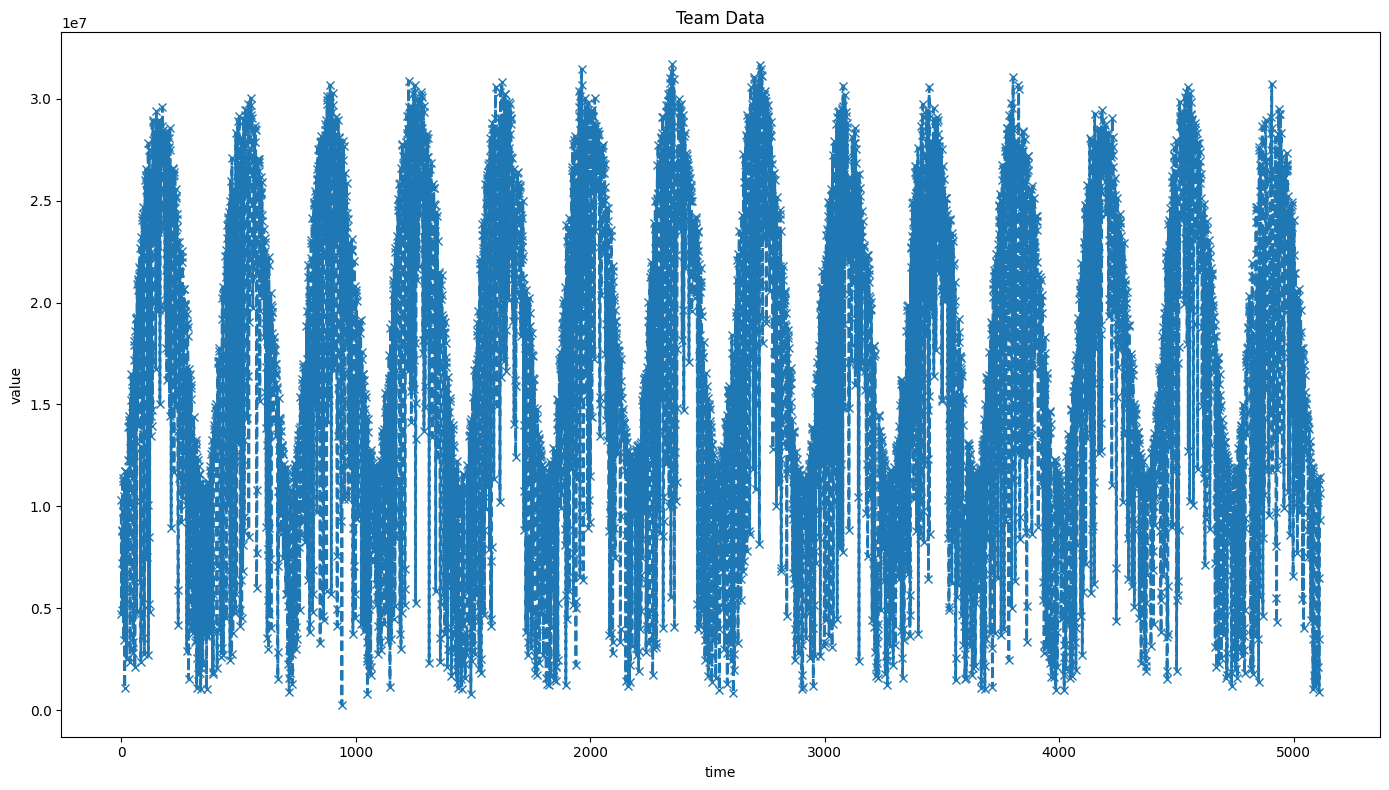

In [6]:
plot_timeseries(A,title='Team Data')

# Question 1

- Assume that A has no trend
- Remove Seasonality (can assume that s = 365)

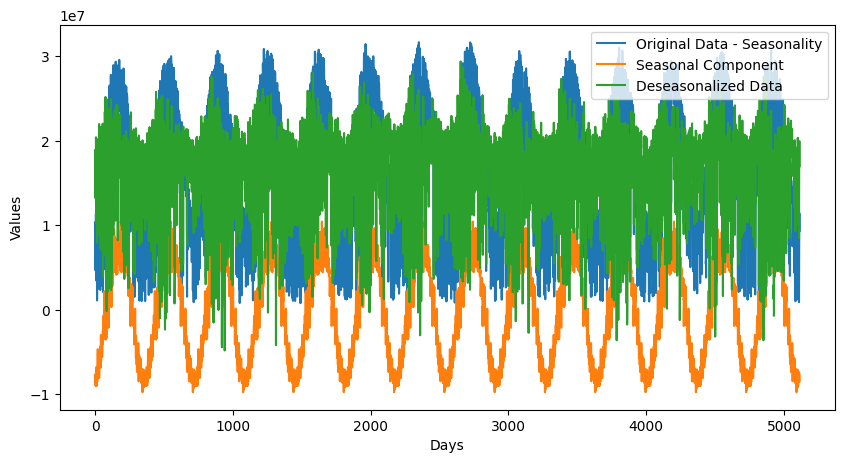

In [7]:
T_season = 365
s = seasonal_components(A, T_season)
A_static= A - s
plt.figure(figsize=(10,5))
plt.plot(A,label='Original Data - Seasonality')
plt.plot(s,label="Seasonal Component")
plt.plot(A_static,label='Deseasonalized Data')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()



# Question 2

- Investigate if the `A_static` is White Noise (WN).
- A time series is considered White Noise (WN) if it satisfies the following conditions:

  1. **Mean**:
     $$
     E[X_t] = 0, \quad \text{for each } t.
     $$

  2. **Variance**:
     $$
     \text{Var}[X_t] = \sigma^2, \quad \text{constant for each } t.
     $$

  3. **Covariance**:
     $$
     \text{Cov}(X_t, X_{t+k}) = 0, \quad \text{the observations are independent from one another.}
     $$


- So i will plot the autocorrelation figure and i will check if the autocorrelation is within the confidence interval. More specifically i will check if the autocorrelation is within the confidence interval for all tau expect tau = 0
- Another way to check the above is to use the portmanteau test

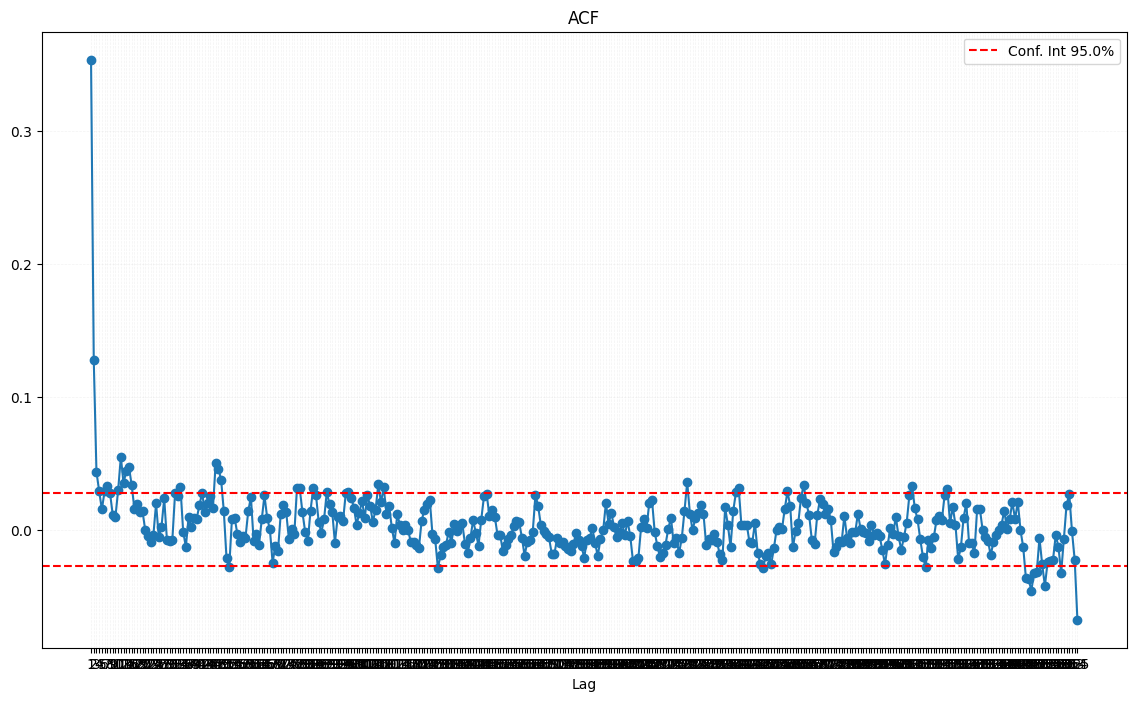

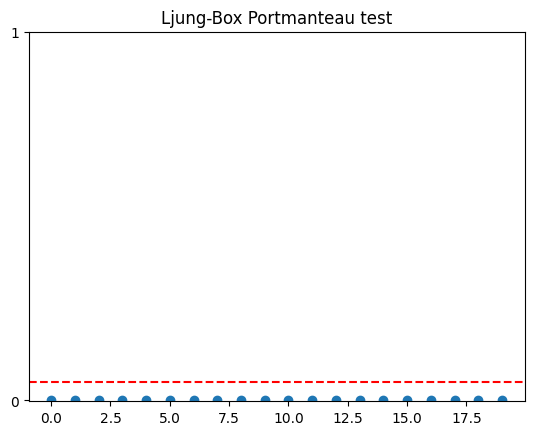

Reject the null hypothesis that the time series is independently distributed.


In [8]:
# # Check the mean
# print(f"Mean of the A_Static timeseries: {np.mean(A_static):.2f}")

# # Check the variance
# print(f"Variance of the A_Static timeseries: {np.var(A_static):.2f}")

# Check the autocorrelation
acfV = get_acf(A_static, lags=365, alpha=0.05, show=True)

#Check the portmanteau test
ljung_val, ljung_pval = portmanteau_test(A_static, maxtau=20, show=True)

if np.any(ljung_pval < 0.05):
    print(f"Reject the null hypothesis that the time series is independently distributed.")
else:
    print(f"Accept the null hypothesis that the time series is independently distributed.")

# Question 3

- Find the best linear model for `A_static`.
- To be this model appropriate, its residuals should be WN

In [9]:
best_linear_model = arimamodel(A_static) #no trend in the data
print(best_linear_model.summary())


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=172883.189, Time=0.19 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=172293.232, Time=0.47 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=172219.518, Time=0.67 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=172215.076, Time=0.80 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=172212.250, Time=1.07 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=172213.755, Time=1.29 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=172203.276, Time=0.33 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=172205.252, Time=0.57 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=172207.233, Time=1.08 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=172208.664, Time=1.32 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=172209.922, Time=1.78 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=172205.219, Time=0.42 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=172207.220, Time=1.11 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=172209.188, Time=2.22 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=172209.160, Time=4.73 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=172207.169, Time=0.50 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=172209.170, Time=1.93 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=172210.999, Time=1.81 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=172207.835, Time=0.65 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=172209.835, Time=2.36 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=172209.835, Time=0.80 sec

Best model:  ARIMA(1,0,0)(0,0,0)[1] intercept
Total fit time: 26.145 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5113
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -86098.638
Date:                Sat, 22 Feb 2025   AIC                         172203.276
Time:                        02:07:59   BIC                         172222.894
Sample:                             0   HQIC                        172210.144
                               - 5113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.077e+07   2.37e-10   4.54e+16      0.000    1.08e+

## Verify the findings using the ACF and PACF

Using the `arimamodel` i found that the best model is ARIMA(1,0,0) = AR(1)

From the figures below i can say that the AR(1) model is appropriate because the PACF is significant only for tau = 1. 

Also because a = 0.05 i can allow 1 error in 20, so i can allow that for tau = 12, the partial autocorrelation is not considered to be 0.

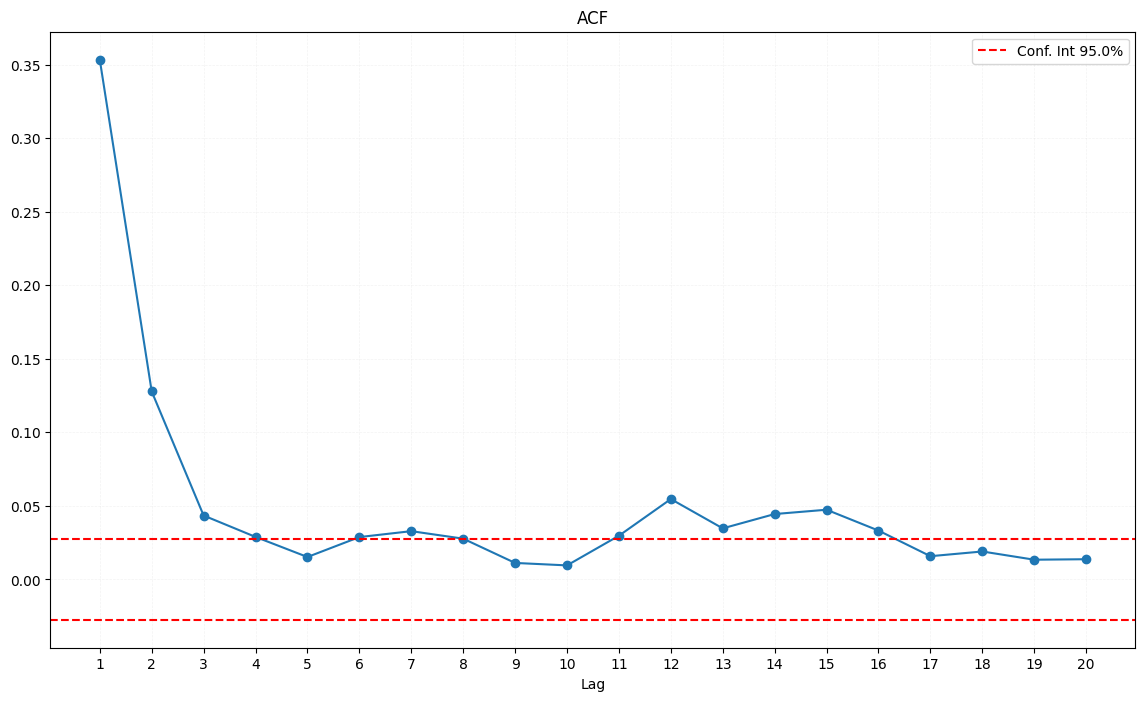

In [10]:
acfV = get_acf(A_static, lags=20, alpha=0.05, show=True)


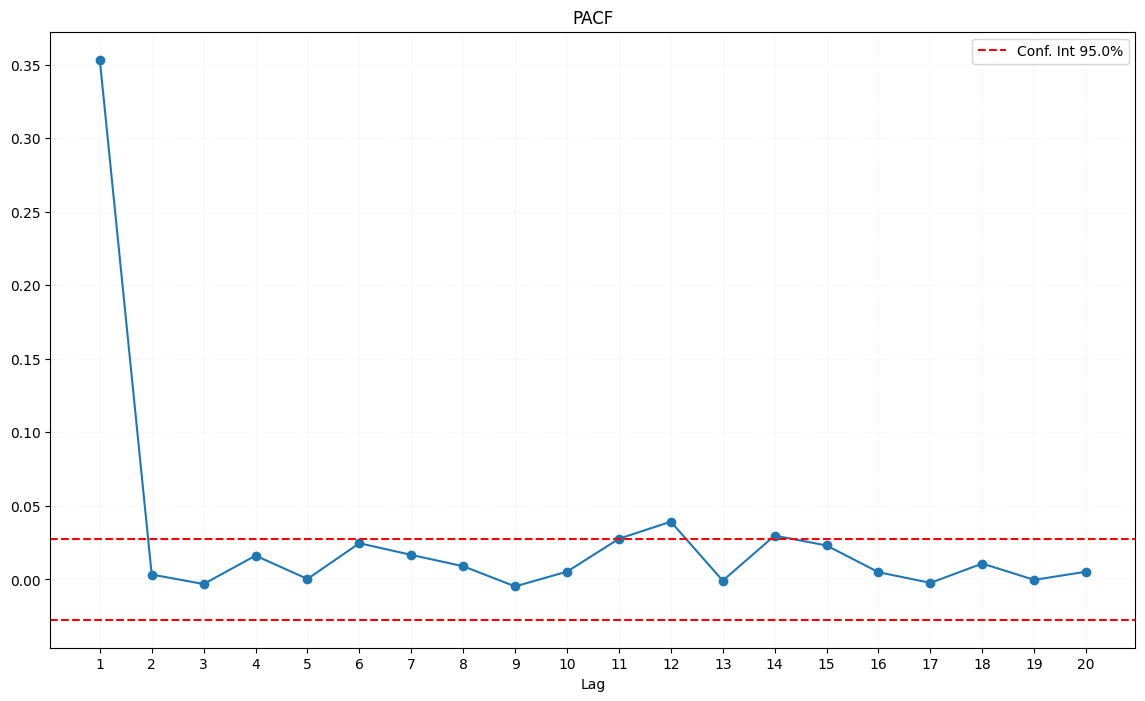

In [11]:
pacfV = get_pacf(A_static, lags=20, alpha=0.05, show=True)

## Chack goodness of fitted model

- plots a histogram of residuals (resid), which should ideally be normally distributed.
- If residuals are uncorrelated (white noise), the model fits well.

In [12]:
best_p = best_linear_model.order[0]
best_q = best_linear_model.order[2]
best_d = best_linear_model.order[1]
summary, fittedvalues, resid, model, aic = fit_arima_model(xV=A_static, p=best_p, q=best_q, d=best_d, show=False)

Mean of the residuals: 23.83
Variance of the residuals: 24764360836694.09


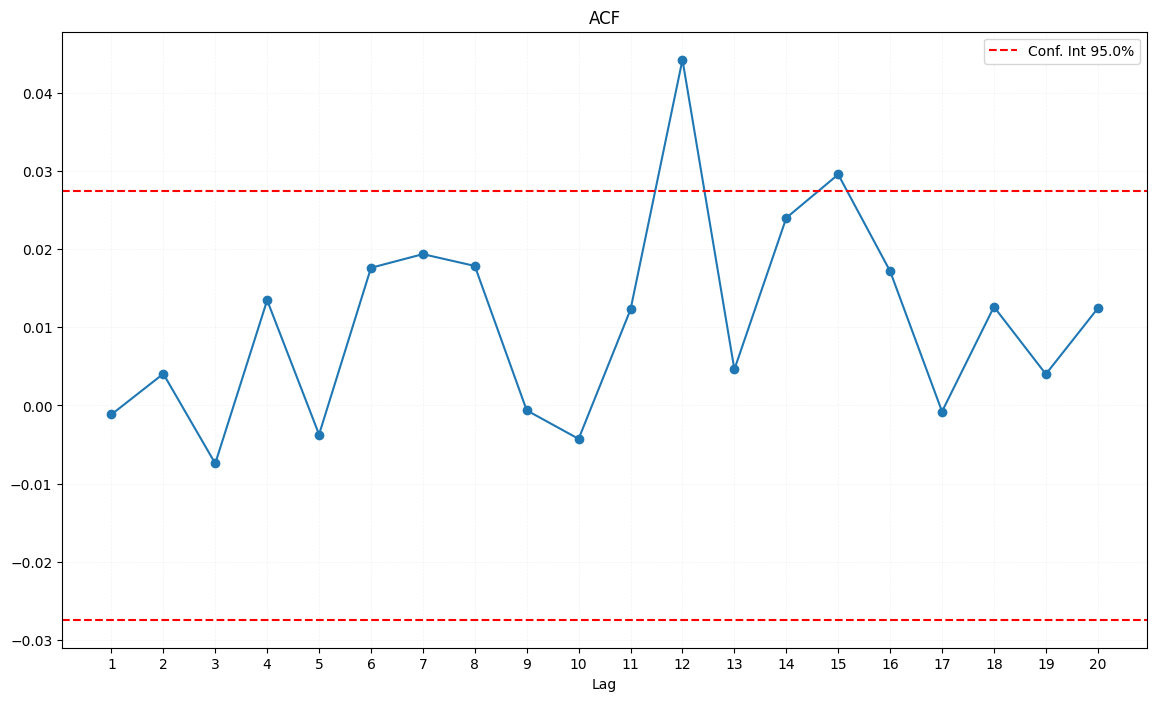

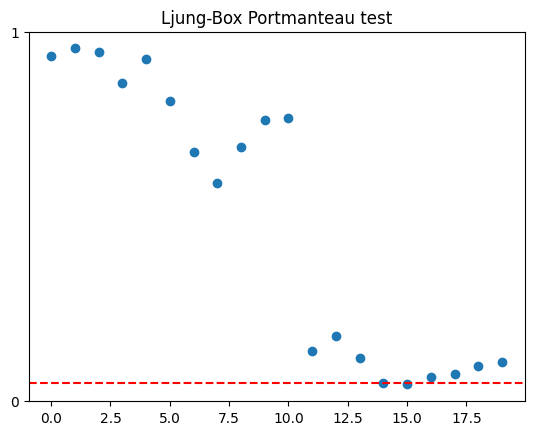

Reject the null hypothesis that the time series is independently distributed.


In [13]:
# Check if the residuals are white noise
print(f"Mean of the residuals: {np.mean(resid):.2f}")   
print(f"Variance of the residuals: {np.var(resid):.2f}")
acfV = get_acf(resid, lags=20, alpha=0.05, show=True)

#Check the portmanteau test
ljung_val, ljung_pval = portmanteau_test(resid, maxtau=20, show=True)
if np.any(ljung_pval < 0.05):
    print(f"Reject the null hypothesis that the time series is independently distributed.")
else:
    print(f"Accept the null hypothesis that the time series is independently distributed.")

# Question 4

In [14]:
# the data are from 1/1/1994 to 31/12/2007
# i will use the data from 1/1/1994 to 31/12/2006 to train the model
# and the data from 1/1/2007 to 31/12/2007 to test the model

data_df['Date'] = pd.to_datetime(data_df['Date'], format='%Y%m%d')  
data_df.set_index('Date', inplace=True)

split = data_df.loc['1994-01-01':'2006-12-31'].shape[0]
print(f"Number of days in the training data: {split}")


Number of days in the training data: 4748


In [15]:

A_static_train = A_static[:split]
A_static_test = A_static[split:]
s_test = s[split:]
s_train = s[:split]


In [16]:

#Find the best ARIMA model for the training data
train_model = arimamodel(A_static_train) #no trend in the data


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=160487.608, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=159964.357, Time=0.50 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=159899.578, Time=0.63 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=159897.231, Time=0.79 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=159896.770, Time=0.94 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=159898.178, Time=1.12 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=159889.003, Time=0.32 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=159891.017, Time=0.62 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=159892.903, Time=0.82 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=159893.880, Time=1.24 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=159895.730, Time=1.70 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=159891.001, Time=0.40 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=159893.001, Time=1.17 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=159894.345, Time=1.98 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=159895.554, Time=3.26 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=159892.289, Time=0.50 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=159894.289, Time=2.16 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=159896.114, Time=2.09 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=159893.674, Time=0.57 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=159895.674, Time=2.58 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=159895.672, Time=0.74 sec

Best model:  ARIMA(1,0,0)(0,0,0)[1] intercept
Total fit time: 24.309 seconds


In [17]:

#Fit the best ARIMA model to the training data
best_p = train_model.order[0]
best_q = train_model.order[2]
best_d = train_model.order[1]
summary, fittedvalues, resid, model, aic = fit_arima_model(xV=A_static_train, p=best_p, q=best_q, d=best_d, show=False)






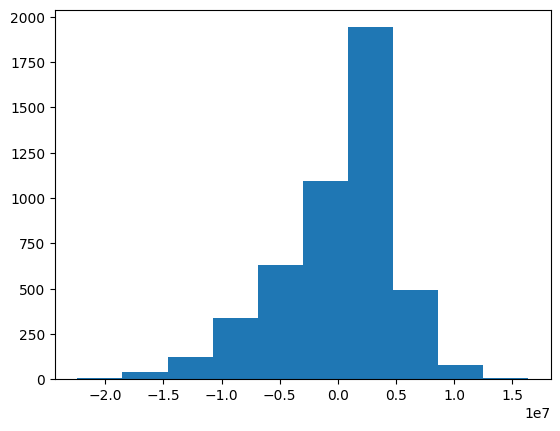

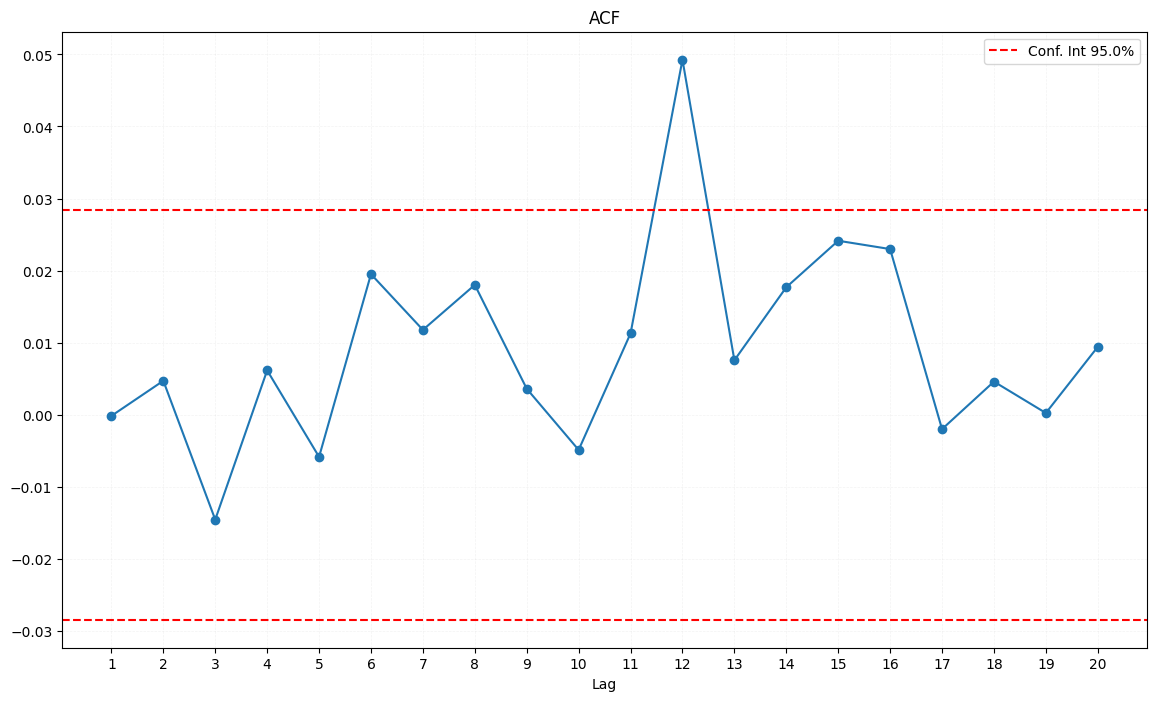

In [18]:
# Check goodness of fitted model
# Check if the residuals are white noise
# and if the residuals are normally distributed
plt.figure()
plt.hist(resid)
acfV = get_acf(resid, lags=20, alpha=0.05, show=True)

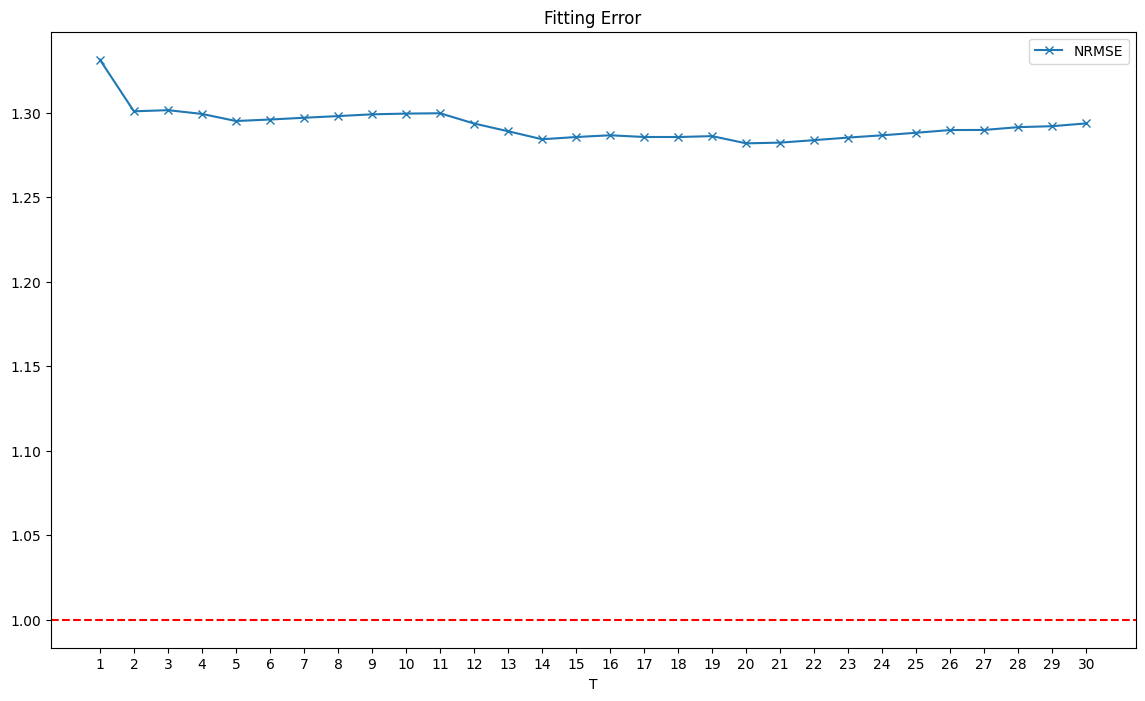

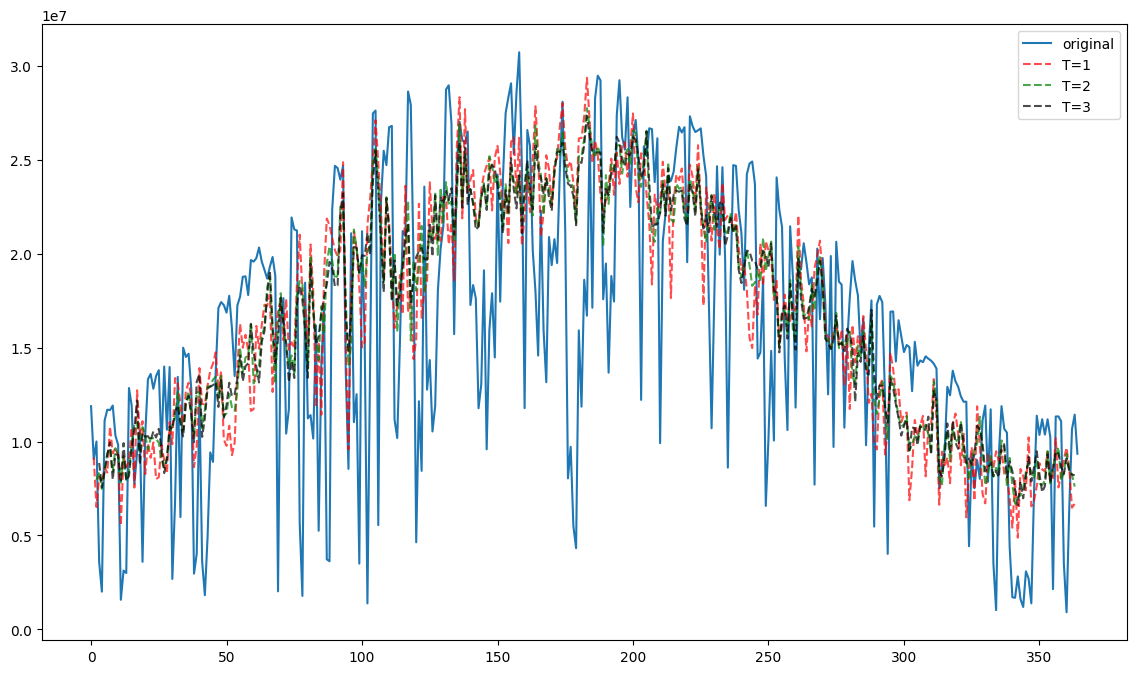

In [19]:
# get fit error
nrmseV, predM = calculate_fitting_error(A_static_test, model, Tmax=31, show=True,original=True,s=s_test)


# Question 5

## First try using seasonality

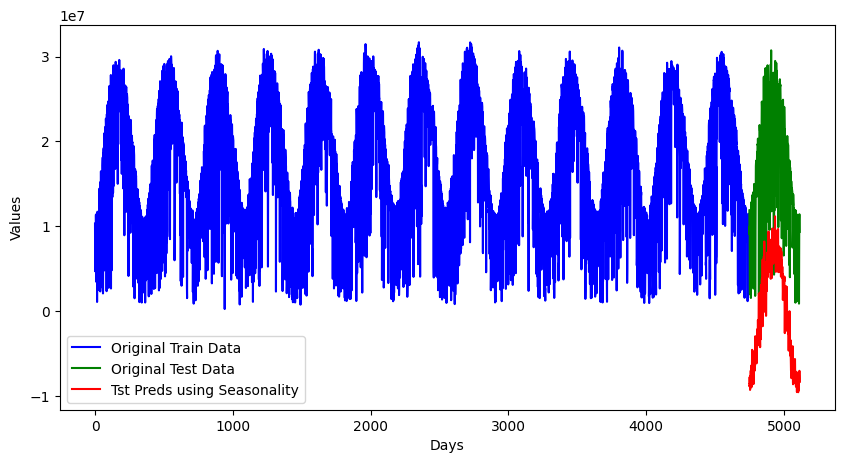

In [20]:
T_season = 365
A_train = A[:split]
A_test = A[split:]
s_train = seasonal_components(A_train, T_season) 
preds = s_train[:T_season] 

plt.figure(figsize=(10,5))
plt.plot(range(split), A_train, label='Original Train Data', color='blue')
plt.plot(range(split, split+T_season), A_test, label='Original Test Data', color='green')
plt.plot(range(split, split+T_season), preds, label='Tst Preds using Seasonality', color='red')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()



## Second try using the mean of each day of the year with T=365

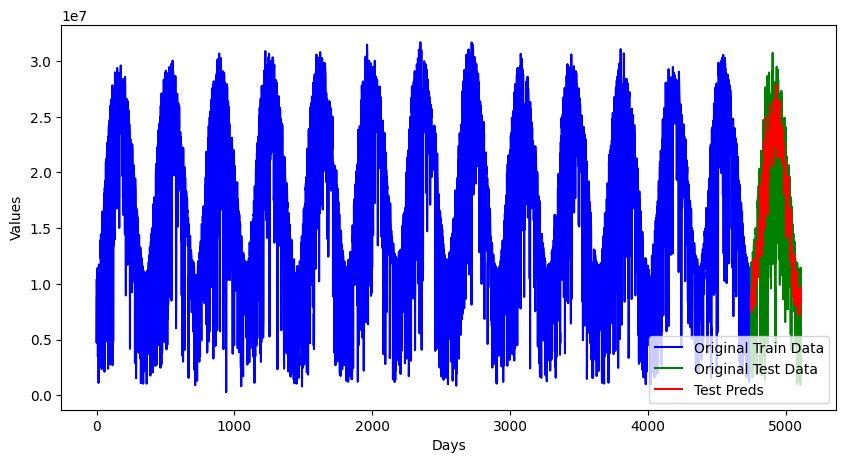

In [21]:
preds = np.full(shape=(T_season,), fill_value=np.nan)

for i in range(T_season):
    preds[i] = A_train[i::T_season].mean()

plt.figure(figsize=(10,5))
plt.plot(range(split), A_train, label='Original Train Data', color='blue')
plt.plot(range(split, split+T_season), A_test, label='Original Test Data', color='green')
plt.plot(range(split, split+T_season), preds, label='Test Preds', color='red')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()



In [22]:
#Get the nrmse for the 2nd try
nrmse_q5 = get_nrmse(A_test,preds)
print(f"nrmse for the 2nd try: {nrmse_q5:.2f}")

#get the nrmse for the ARIMA model in q4
nrmse_q4 = nrmseV[1]
print(f"nrmse for the ARIMA model in q4: {nrmse_q4:.2f}")


nrmse for the 2nd try: 0.81
nrmse for the ARIMA model in q4: 1.33


# Question 6

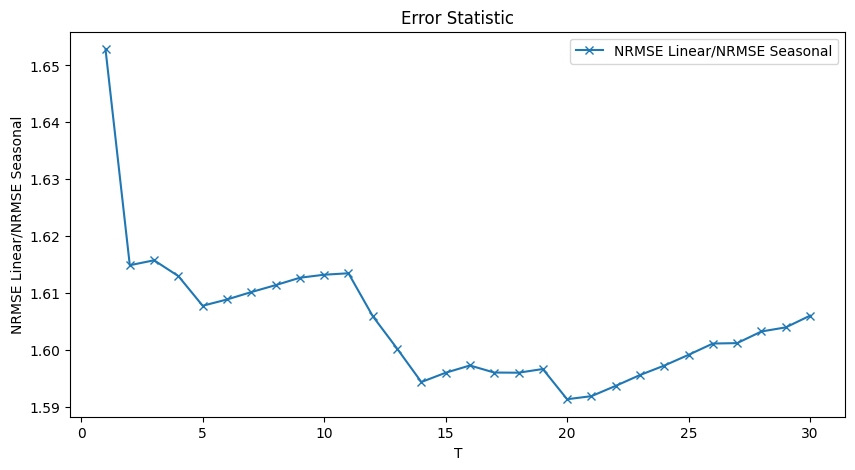

In [23]:
def new_error_stat(nrmse_linear, nrmse_seasonal,show=False):
    T_max = nrmse_linear.shape[0]
    snrmse = nrmse_linear/nrmse_seasonal
    if show:
        plt.figure(figsize=(10,5))
        plt.plot(range(T_max), snrmse, marker='x', label='NRMSE Linear/NRMSE Seasonal')
        plt.xlabel('T')
        plt.ylabel('NRMSE Linear/NRMSE Seasonal')
        plt.title('Error Statistic')
        plt.legend()
        plt.show()
    return snrmse

snrmse = new_error_stat(nrmseV, nrmse_q5, show=True)

# Question 7 

# Local Average Prediction - Local Linear Model with PCR - Standrard Local Linear Model

## Find the appropriate tau

In order to find the best tau, i will have to find the tau that corresponds to the first local minimum of the Mutal Information

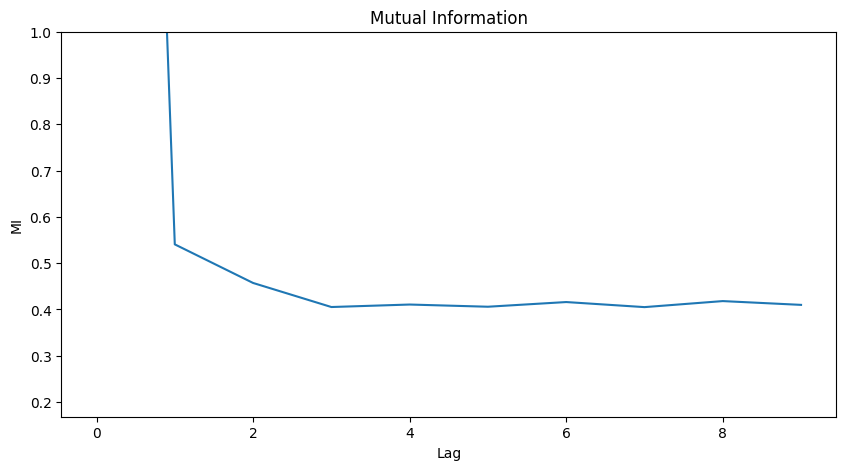

In [24]:
mi = delay.dmi(A_static,maxtau=10)
plt.figure(figsize=(10,5))
plt.plot(mi)
plt.ylim(top=1)
plt.xlabel('Lag')
plt.ylabel('MI')
plt.title('Mutual Information')
plt.show()

Another way to find the best tau is by using the autocorrelation function and assigning tau to the tau that rx(tau) = 0 for the first time

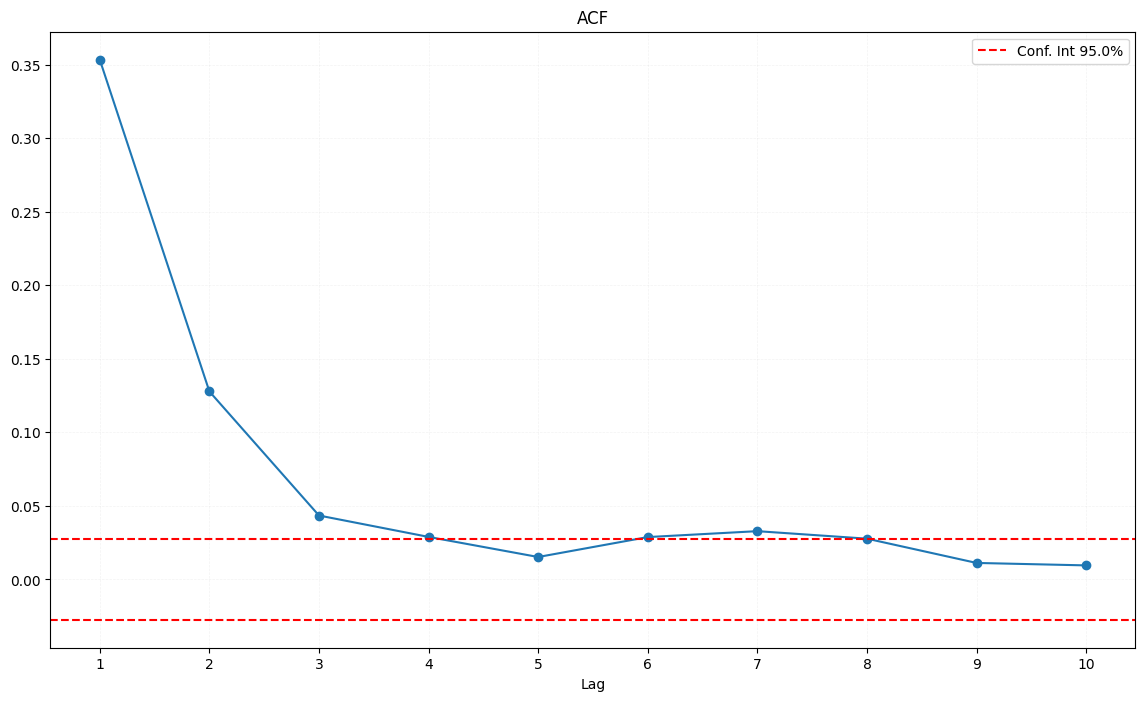

In [25]:
acV = get_acf(A_static, lags=10, alpha=0.05, show=True)

In [26]:
tau_est = 5


## Find the appropriate m

I will use the falsenearestfunction to find the m.

The appropriate m is the smallest m which false neighbors percentage is close to 0

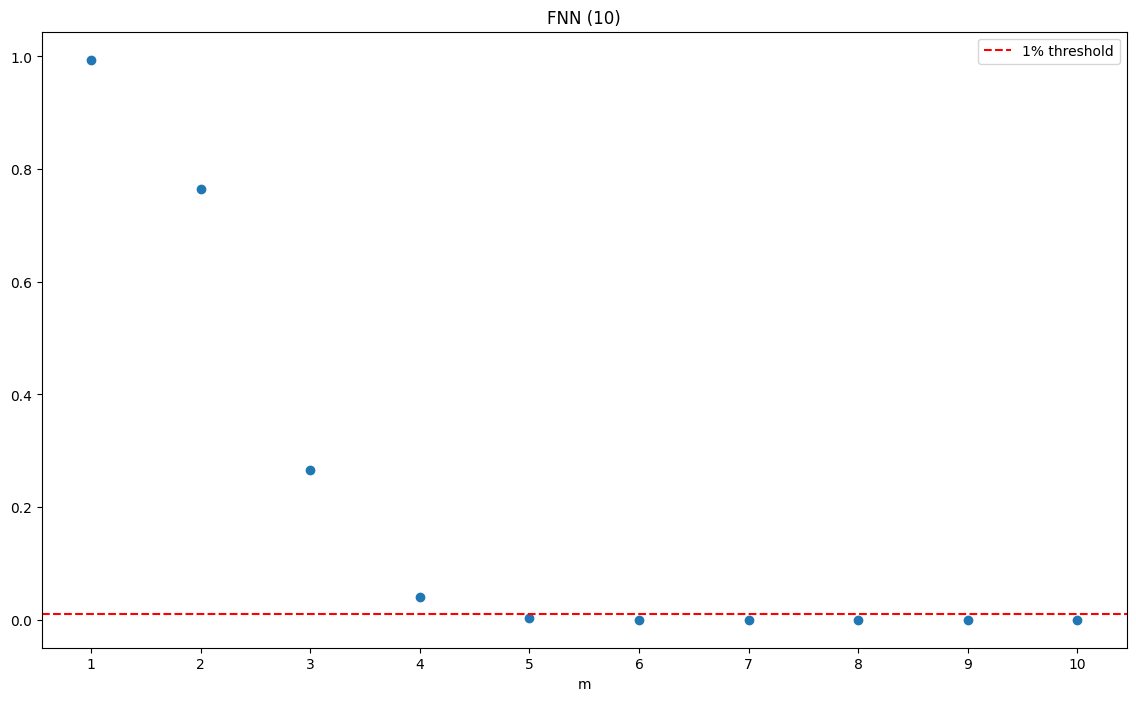

In [27]:
p_fnn = falsenearestneighbors(A_static, m_max=10, tau=tau_est, show=True)

In [28]:
m_est = 5

### q=0 -> Local Average Model

FOR DEBUGGING : nvec: 5083, m: 5, tau: 5
 winnowM shape: (5083, 25)
FOR DEBUGGING : xV[0:5083].shape: (5083,)
FOR DEBUGGING : xV[1:5084].shape: (5083,)
FOR DEBUGGING : xV[2:5085].shape: (5083,)
FOR DEBUGGING : xV[3:5086].shape: (5083,)
FOR DEBUGGING : xV[4:5087].shape: (5083,)
FOR DEBUGGING : xV[5:5088].shape: (5083,)
FOR DEBUGGING : xV[6:5089].shape: (5083,)
FOR DEBUGGING : xV[7:5090].shape: (5083,)
FOR DEBUGGING : xV[8:5091].shape: (5083,)
FOR DEBUGGING : xV[9:5092].shape: (5083,)
FOR DEBUGGING : xV[10:5093].shape: (5083,)
FOR DEBUGGING : xV[11:5094].shape: (5083,)
FOR DEBUGGING : xV[12:5095].shape: (5083,)
FOR DEBUGGING : xV[13:5096].shape: (5083,)
FOR DEBUGGING : xV[14:5097].shape: (5083,)
FOR DEBUGGING : xV[15:5098].shape: (5083,)
FOR DEBUGGING : xV[16:5099].shape: (5083,)
FOR DEBUGGING : xV[17:5100].shape: (5083,)
FOR DEBUGGING : xV[18:5101].shape: (5083,)
FOR DEBUGGING : xV[19:5102].shape: (5083,)
FOR DEBUGGING : xV[20:5103].shape: (5083,)
FOR DEBUGGING : xV[21:5104].shape: (508

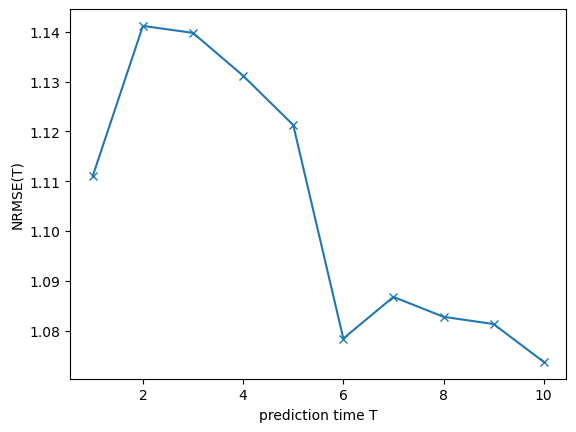

In [29]:
Tmax_val=10


nrmse_q7a, preM_q7a = localfitnrmse(A_static, tau=tau_est, m=m_est, Tmax=Tmax_val, nnei=4, q=0, show=True) 
# resid_q7a = A_static - preM_q7a[:, 0]
# resid_q7a = A_static[(m_est - 1) * tau_est + Tmax_val : ] - preM_q7a[:, 0] #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
resid_q7a = A_static[(m_est - 1) * tau_est + 1 : (m_est - 1) * tau_est + 1 + len(preM_q7a)] - preM_q7a[:, 0]


nrmse.shape: (10, 1)
preM.shape: (5083, 10)


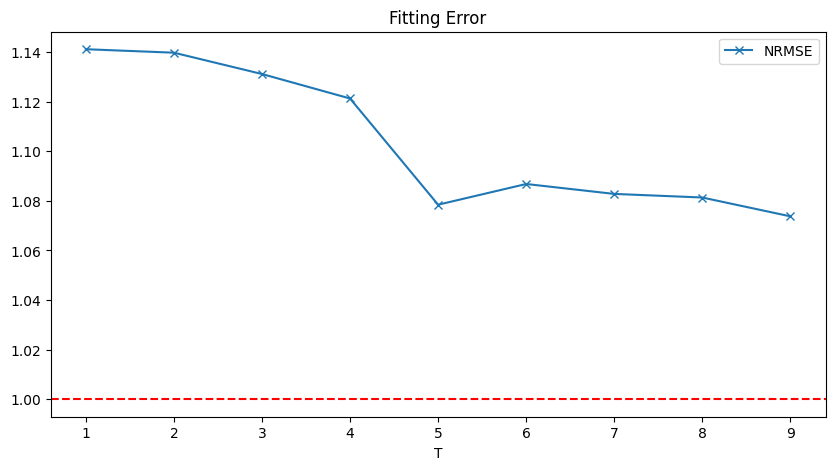

In [30]:
print(f"nrmse.shape: {nrmse_q7a.shape}")
print(f"preM.shape: {preM_q7a.shape}")
plt.figure(figsize=(10,5))
plt.plot(range(1, Tmax_val), nrmse_q7a[1:], marker='x', label='NRMSE');
plt.axhline(1, color='red', linestyle='--');
plt.title('Fitting Error')
plt.xlabel('T')
plt.xticks(range(1, Tmax_val))
plt.legend()
plt.show()

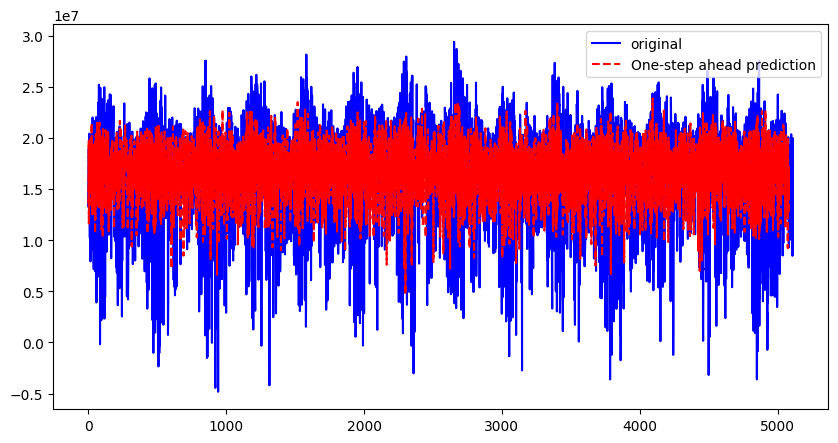

In [31]:
plt.figure(figsize=(10,5))
plt.plot(A_static, label='original', color='blue')
plt.plot(preM_q7a[:,0],label='One-step ahead prediction', linestyle='--', color='red')
#plt.plot(preM_q7[:,1],label='Two-step ahead prediction', linestyle='--', color='green')
#plt.plot(preM_q7[:,2],label='Three-step ahead prediction', linestyle='--', color='black')
plt.legend()
plt.show()

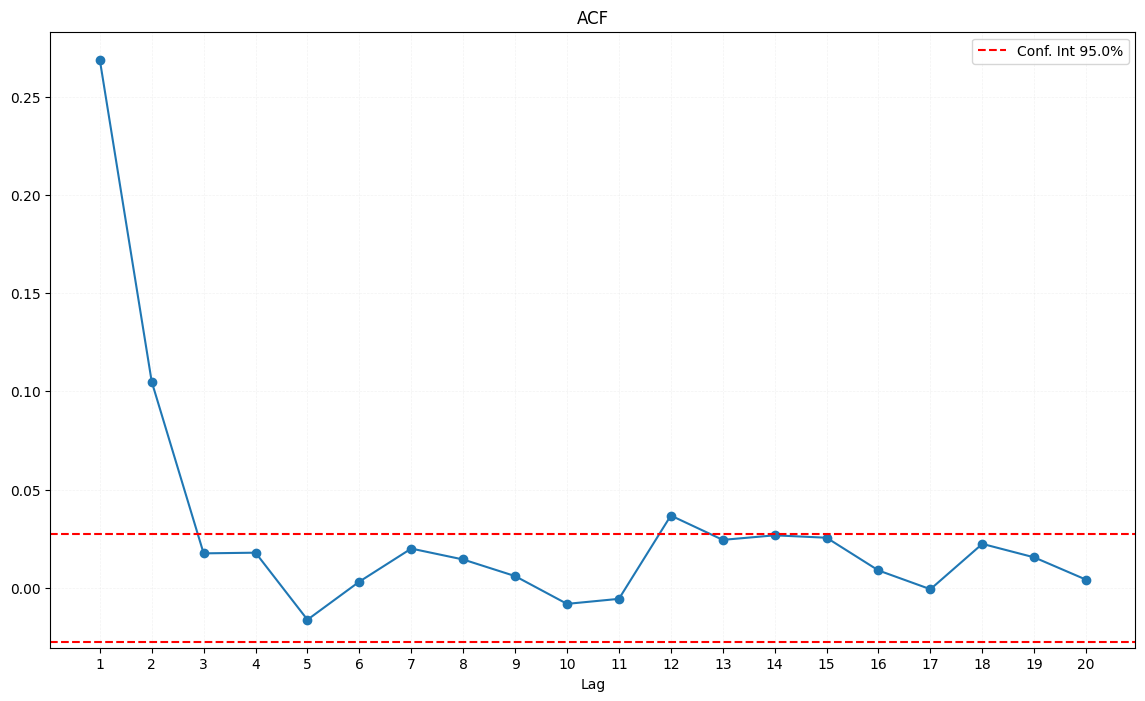

In [32]:
acfV = get_acf(resid_q7a, lags=20, alpha=0.05, show=True)    

### q < m -> Principal Component Regression

FOR DEBUGGING : nvec: 5083, m: 5, tau: 5
 winnowM shape: (5083, 25)
FOR DEBUGGING : xV[0:5083].shape: (5083,)
FOR DEBUGGING : xV[1:5084].shape: (5083,)
FOR DEBUGGING : xV[2:5085].shape: (5083,)
FOR DEBUGGING : xV[3:5086].shape: (5083,)
FOR DEBUGGING : xV[4:5087].shape: (5083,)
FOR DEBUGGING : xV[5:5088].shape: (5083,)
FOR DEBUGGING : xV[6:5089].shape: (5083,)
FOR DEBUGGING : xV[7:5090].shape: (5083,)
FOR DEBUGGING : xV[8:5091].shape: (5083,)
FOR DEBUGGING : xV[9:5092].shape: (5083,)
FOR DEBUGGING : xV[10:5093].shape: (5083,)
FOR DEBUGGING : xV[11:5094].shape: (5083,)
FOR DEBUGGING : xV[12:5095].shape: (5083,)
FOR DEBUGGING : xV[13:5096].shape: (5083,)
FOR DEBUGGING : xV[14:5097].shape: (5083,)
FOR DEBUGGING : xV[15:5098].shape: (5083,)
FOR DEBUGGING : xV[16:5099].shape: (5083,)
FOR DEBUGGING : xV[17:5100].shape: (5083,)
FOR DEBUGGING : xV[18:5101].shape: (5083,)
FOR DEBUGGING : xV[19:5102].shape: (5083,)
FOR DEBUGGING : xV[20:5103].shape: (5083,)
FOR DEBUGGING : xV[21:5104].shape: (508

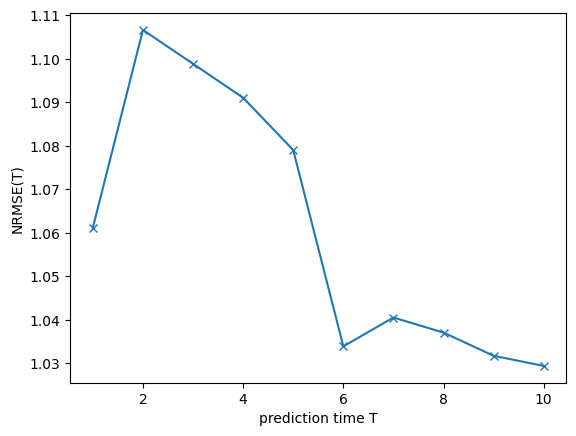

In [33]:
q_bar = 2
nrmse_q7b, preM_q7b = localfitnrmse(A_static, tau=tau_est, m=m_est, Tmax=10, nnei=10, q=q_bar, show=True)
#resid_q7b = A_static[(m_est - 1) * tau_est + Tmax : ] - preM_q7b[:, 0]
resid_q7b = A_static[(m_est - 1) * tau_est + 1 : (m_est - 1) * tau_est + 1 + len(preM_q7b)] - preM_q7b[:, 0]

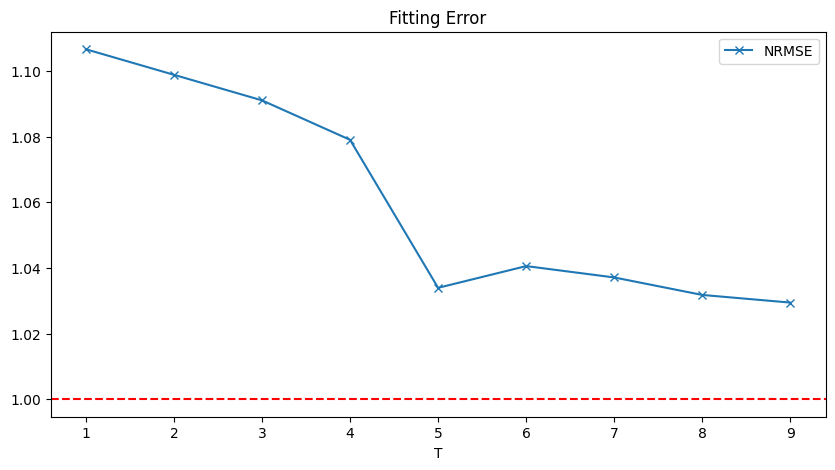

In [34]:
plt.figure(figsize=(10,5))
plt.plot(range(1, Tmax_val), nrmse_q7b[1:], marker='x', label='NRMSE');
plt.axhline(1, color='red', linestyle='--');
plt.title('Fitting Error')
plt.xlabel('T')
plt.xticks(range(1, Tmax_val))
plt.legend()
plt.show()

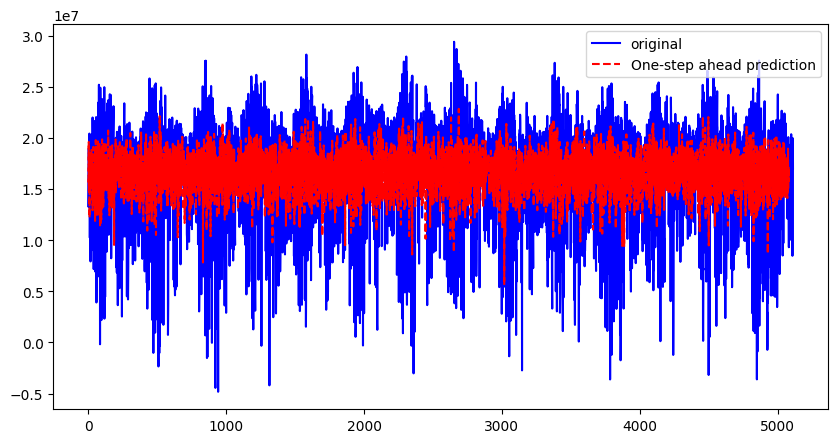

In [35]:
plt.figure(figsize=(10,5))
plt.plot(A_static, label='original', color='blue')
plt.plot(preM_q7b[:,0],label='One-step ahead prediction', linestyle='--', color='red')
#plt.plot(preM_q7b[:,1],label='Two-step ahead prediction', linestyle='--', color='green')
#plt.plot(preM_q7b[:,2],label='Three-step ahead prediction', linestyle='--', color='black')
plt.legend()
plt.show()

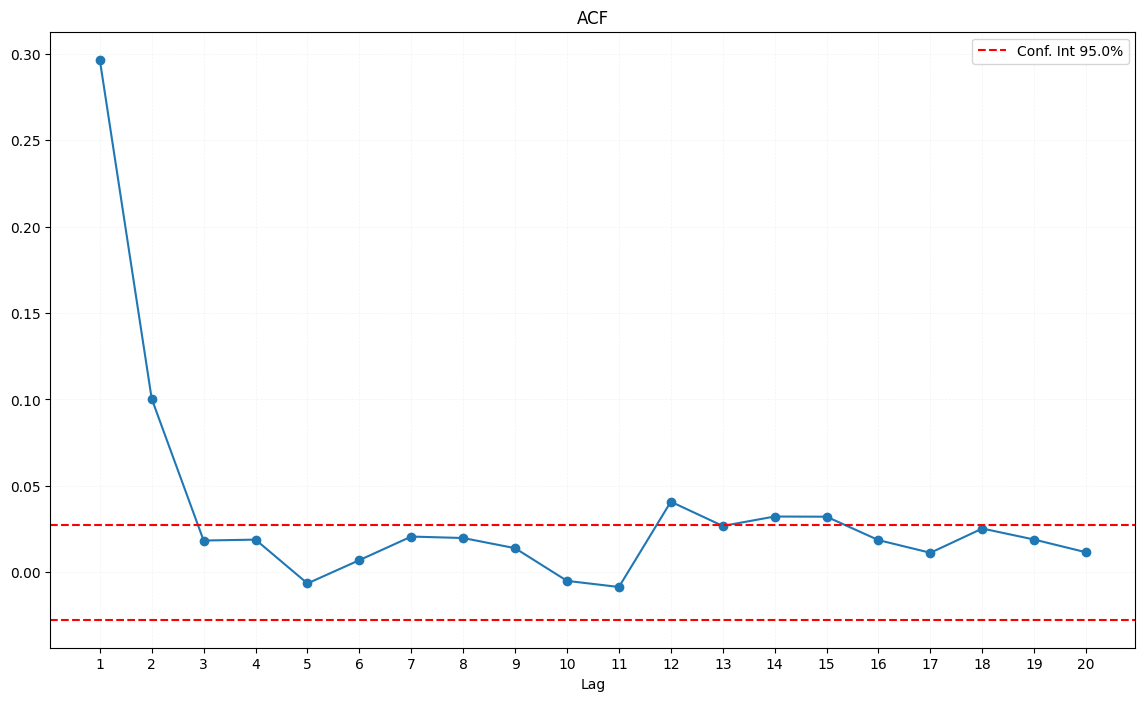

In [36]:
acf_b = get_acf(resid_q7b, lags=20, alpha=0.05, show=True)

### q >= m -> Ordinary Least Squares

FOR DEBUGGING : nvec: 5083, m: 5, tau: 5
 winnowM shape: (5083, 25)
FOR DEBUGGING : xV[0:5083].shape: (5083,)
FOR DEBUGGING : xV[1:5084].shape: (5083,)
FOR DEBUGGING : xV[2:5085].shape: (5083,)
FOR DEBUGGING : xV[3:5086].shape: (5083,)
FOR DEBUGGING : xV[4:5087].shape: (5083,)
FOR DEBUGGING : xV[5:5088].shape: (5083,)
FOR DEBUGGING : xV[6:5089].shape: (5083,)
FOR DEBUGGING : xV[7:5090].shape: (5083,)
FOR DEBUGGING : xV[8:5091].shape: (5083,)
FOR DEBUGGING : xV[9:5092].shape: (5083,)
FOR DEBUGGING : xV[10:5093].shape: (5083,)
FOR DEBUGGING : xV[11:5094].shape: (5083,)
FOR DEBUGGING : xV[12:5095].shape: (5083,)
FOR DEBUGGING : xV[13:5096].shape: (5083,)
FOR DEBUGGING : xV[14:5097].shape: (5083,)
FOR DEBUGGING : xV[15:5098].shape: (5083,)
FOR DEBUGGING : xV[16:5099].shape: (5083,)
FOR DEBUGGING : xV[17:5100].shape: (5083,)
FOR DEBUGGING : xV[18:5101].shape: (5083,)
FOR DEBUGGING : xV[19:5102].shape: (5083,)
FOR DEBUGGING : xV[20:5103].shape: (5083,)
FOR DEBUGGING : xV[21:5104].shape: (508

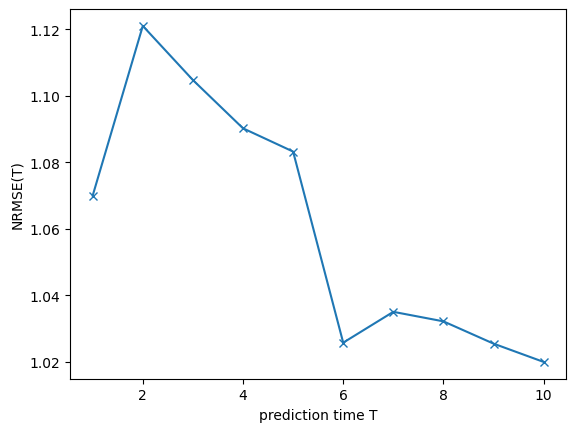

In [37]:
nrmse_q7c, preM_q7c = localfitnrmse(A_static, tau=tau_est, m=m_est, Tmax=10, nnei=30, q=m_est, show=True)
resid_q7c = A_static[(m_est - 1) * tau_est + 1 : (m_est - 1) * tau_est + 1 + len(preM_q7c)] - preM_q7c[:, 0]


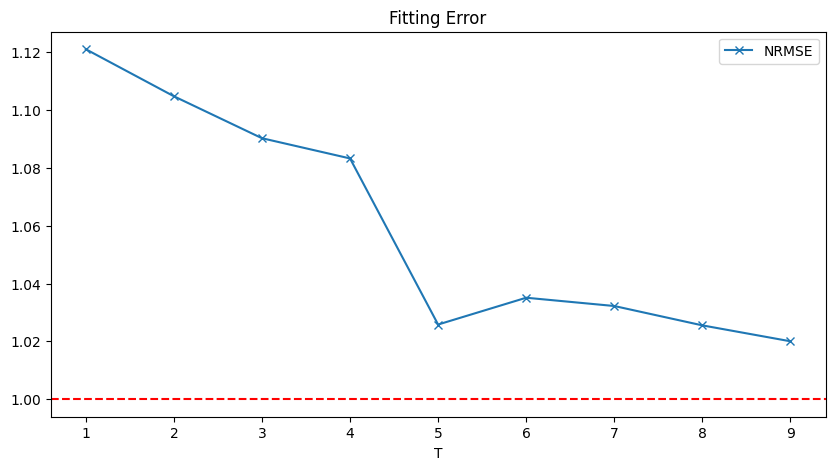

In [38]:
plt.figure(figsize=(10,5))
plt.plot(range(1, Tmax_val), nrmse_q7c[1:], marker='x', label='NRMSE');
plt.axhline(1, color='red', linestyle='--');
plt.title('Fitting Error')
plt.xlabel('T')
plt.xticks(range(1, Tmax_val))
plt.legend()
plt.show()

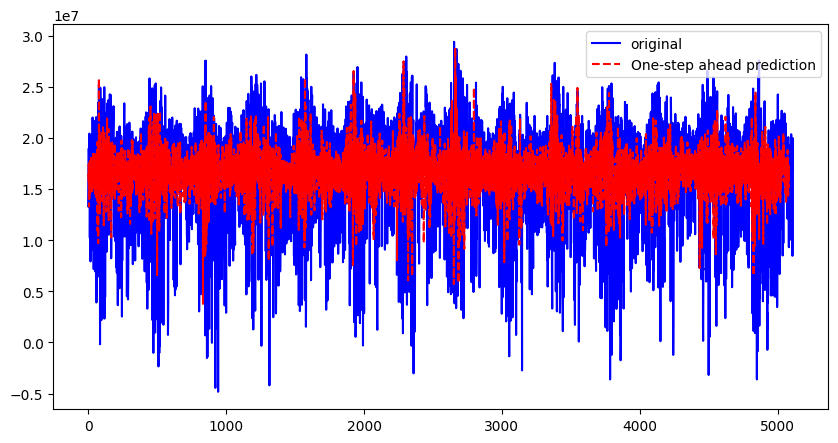

In [39]:
plt.figure(figsize=(10,5))
plt.plot(A_static, label='original', color='blue')
plt.plot(preM_q7c[:,0],label='One-step ahead prediction', linestyle='--', color='red')
#plt.plot(preM_q7c[:,1],label='Two-step ahead prediction', linestyle='--', color='green')
#plt.plot(preM_q7c[:,2],label='Three-step ahead prediction', linestyle='--', color='black')
plt.legend()
plt.show()

# MLP

In [40]:
# Create input - output pairs for the MLP model using lagged observsations

def create_dataset(data, n_steps):
    X, y = [], []  # Initialize empty lists for features (X) and labels (y)
    for i in range(len(data) - n_steps):  # i =0 1 2 ... len(data) - n_steps
        X.append(data[i:(i + n_steps)])  # Append n_steps lagged values to X
        y.append(data[i + n_steps])       # Append the next value (target) to y
    return np.array(X), np.array(y)      # Convert lists to NumPy arrays


In [41]:

n_steps = 10


X_train,y_train = create_dataset(A_static_train, n_steps)
X_test,y_test = create_dataset(A_static_test, n_steps)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")




X_train.shape: (4738, 10)
y_train.shape: (4738,)
X_test.shape: (355, 10)
y_test.shape: (355,)


In [42]:

from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor



scaler = StandardScaler()
#pca = PCA(n_components=0.95)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled.shape: {X_train_scaled.shape}")
print(f"y_train_scaled.shape: {X_test_scaled.shape}")



X_train_scaled.shape: (4738, 10)
y_train_scaled.shape: (355, 10)


In [43]:
mlp = MLPRegressor(hidden_layer_sizes=(256, 128,32), activation='relu',momentum=0.8 ,max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)


nrmse_mlp: 0.93


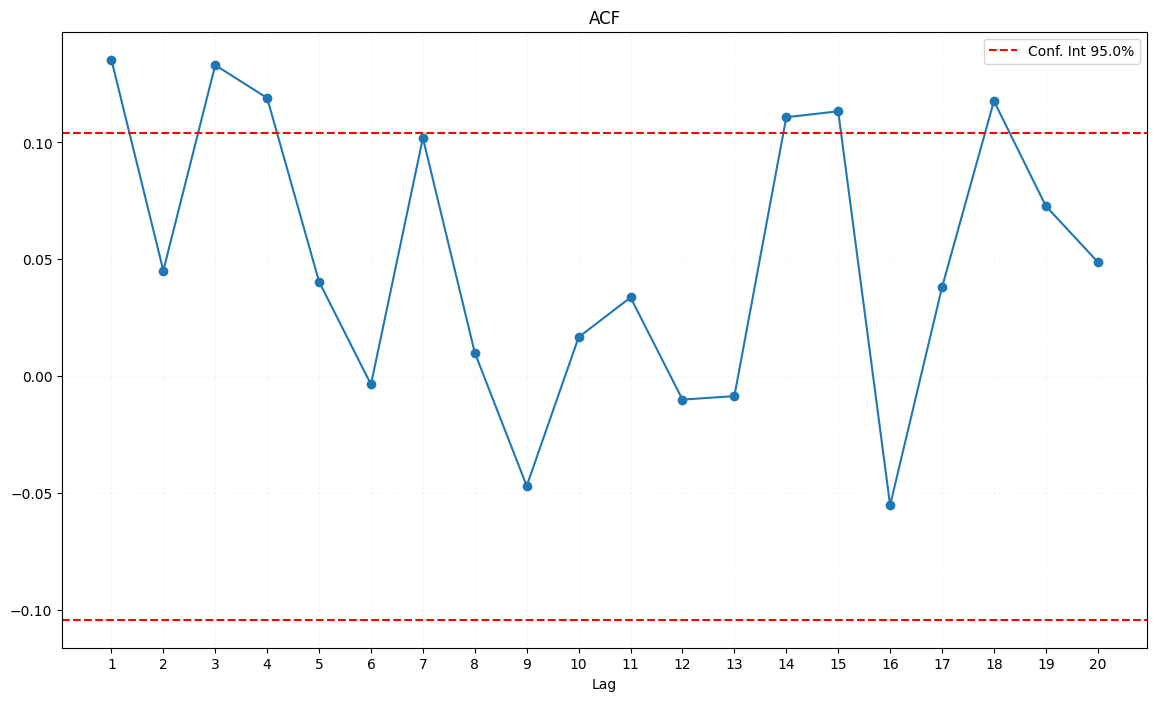

In [48]:

resid_mlp = y_test - y_pred
nrmse_mlp = get_nrmse(y_test, y_pred)
print(f"nrmse_mlp: {nrmse_mlp:.2f}")
acfV = get_acf(resid_mlp, lags=20, alpha=0.05, show=True)

# SVM

In [49]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly', 'sigmoid'], 'verbose': [True]}
grid = GridSearchCV(svr, param_grid, cv=5, n_jobs=-1)

grid.fit(X_train_scaled, y_train)


[LibSVM]

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'verbose': [True]})

nrmse_svr: 1.09


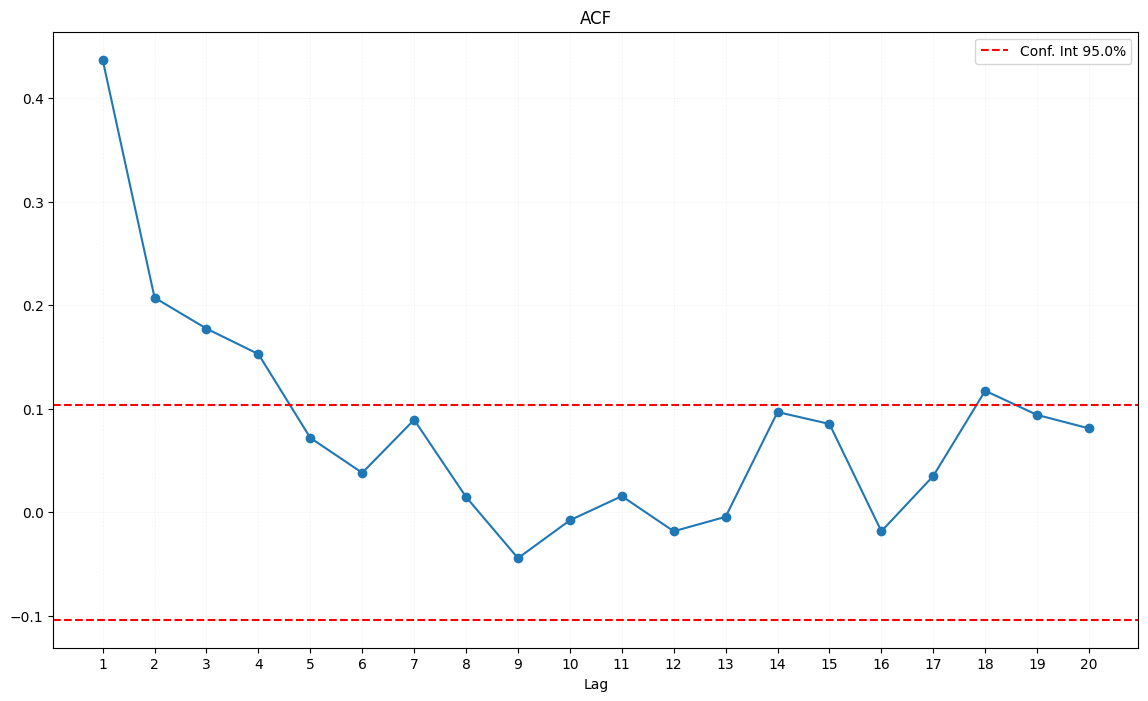

In [50]:
best_svr = grid.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)
nrmse_svr = get_nrmse(y_test, y_pred_svr)
print(f"nrmse_svr: {nrmse_svr:.2f}")
resid_svr = y_test - y_pred_svr
acfV = get_acf(resid_svr, lags=20, alpha=0.05, show=True)



In [46]:




# create a scikit learn wrapper for the PyTorch MLP
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin


class PyTorchMLPRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device, learning_rate, epochs, momentum, classes=None, weight_decay=1e-4, class_weights=None, reduction='mean'):
        self.model = model
        self.device = device
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.momentum = momentum
        self.weight_decay = weight_decay
        #self.class_weights = class_weights
        self.reduction = reduction
        #self.classes = classes
        # self.X_train = torch.from_numpy(X_train).to(self.device).type(torch.float32)
        # self.y_train = torch.from_numpy(y_train).to(self.device).type(torch.long) - 1
        # self.X_test = torch.from_numpy(X_test).to(self.device).type(torch.float32)
        # print(y_test)
        # self.y_test = torch.from_numpy(y_test).to(self.device).type(torch.long) - 1

    def fit(self,X_train,y_train):  

        #self.classes = np.unique(y_train) 
        X_train_tensor = torch.from_numpy(X_train).to(self.device).type(torch.float32)
        
        y_train_tensor = torch.from_numpy(y_train).to(self.device).type(torch.float32).view(-1,1)
        
        
        #put model to the gpu if available
        self.model = self.model.to(self.device)

        #self.class_weights = torch.tensor(self.class_weights).to(self.device).type(torch.float32)
        #define the loss function and the optimizer
        loss_fn = nn.MSELoss() 
        optimizer = optim.SGD(self.model.parameters(),lr=self.learning_rate,momentum=self.momentum,weight_decay=self.weight_decay) #check memomtum and other optimizers


        #train the model
        for epoch in range(self.epochs):
            self.model.train()
            #forward pass   
            y_logits = self.model(X_train_tensor)
            #calculate the loss
            loss = loss_fn(y_logits,y_train_tensor)
            #optimizer zero grad
            optimizer.zero_grad()
            #loss backwards
            loss.backward()
            #optimizer step
            optimizer.step()

        return self
    
    def predict(self, X_test):
            
            X_test_tensor = torch.from_numpy(X_test).to(self.device).type(torch.float32) #convert the test data to tensor
            # y_test_tensor = torch.from_numpy(y_test).to(self.device).type(torch.long) - 1

            # put model to evaluation mode
            self.model.eval()
            with torch.inference_mode(): # turn off the gradient computation
                y_preds = self.model(X_test_tensor)
                # y_preds = torch.argmax(y_preds,dim=1)
                # acc = accuracy_score(self.y_test.cpu() + 1,y_preds.cpu() + 1) * 100
                # print(f"Accuracy: {acc:.4f} %")
                # print(np.unique(y_preds.cpu().numpy() + 1))
                return y_preds.cpu().numpy() 
            
    # predict the probabilities
    def predict_proba(self, X_test):
        X_test_tensor = torch.from_numpy(X_test).to(self.device).type(torch.float32)
        self.model.eval()
        with torch.inference_mode():
            y_logits = self.model(X_test_tensor)
            y_probs = torch.softmax(y_logits, dim=1)
        return y_probs.cpu().numpy()
    


class MLP(nn.Module): # create a PyTorch MLP model
    def __init__(self, input_size, hidden_units):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_units), # input layer
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=1), # hidden layer
        )

    def forward(self, x):
        return self.layer(x)
    

mlp_model = MLP(input_size=X_train_scaled.shape[1], hidden_units=100)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

pytorch_mlp = PyTorchMLPRegressor(model=mlp_model, device=device, learning_rate=0.01, epochs=100, momentum=0.9)


pytorch_mlp.fit(X_train_scaled, y_train)

y_preds = pytorch_mlp.predict(X_test_scaled)


Device: cuda


In [47]:
y_preds

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      